In [4]:
import torch
import numpy as np
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))


In [10]:
import torch.nn as nn
import torch.nn.functional as F

# Each layer should be convolution -> batch norm (optional) -> leaky ReLU
# conv function will put these layers together sequentialy.
# Use PyTorch's Sequential container which takes in a list of layers and creates 
# layers according to the order that they are passed in to the Sequential constructor.
# A strided convolutional layer and an optional batch norm layer
#
# https://pytorch.org/docs/stable/nn.html#batchnorm2d
# https://pytorch.org/docs/stable/nn.html#sequential
#
# We will use kernel_size = 4 & stride = 2, will reduce size of image by 2
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    # bias is set to False, so the layers are not offset by any amount
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
# Use batch normalization with nn.BatchNorm2d on each layer except 
# the 1st convolutional layer and final linear output layer.
# In the DCGAN paper, they did all the downsampling using only strided 
# convolutional layers with no maxpooling layers

class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input, 16x16 output
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 1st layer, no batch_norm 
        self.conv2 = conv(conv_dim, conv_dim*2, 4)   # 8x8 output
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # 4x4 output
        
        # final fully-connected layer - produces 1 output (par 2)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, xx):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(xx),  0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out

In [12]:
# define a function that will allow us to do:
# transpose convolution -> batch norm (optional: T/F) -> ReLU
# Use kernel_size 4 & stride 2 for transpose convolutions

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Create a transposed-convolutional layer with optional batch normalization """
    # create a sequence of transpose + optional batch norm layers
    layers = [] # empty list of layers
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
# In G 1st layer is a fully connected layer which is reshaped into a deep and narrow layer, eg. 4x4x512
# Then use batch norm & leaky ReLU activation
# Next is a series of transpose convolutional layers where you typically halve the depth 
# and double the width and height of the previous layer
# Apply batch normalization and ReLU to all but the last hidden layer. Where we apply a tanh activation

# Input: randomly generated vector z
# Output tanh values of size 32x32 which is the size of the SVHN images

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first fully-connected layer, 
        # params: latent verctor z & produces a layer 4x4x128
        #         4x4 part defined in the forward step below
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers, kernel_size = 4,
        # desired depth for RGB image is 3
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, xx):
        # fully-connected + reshape 
        out = self.fc(xx)
        # params: batch_size, depth, 4, 4
        # -1 is a place holder for batch size
        # 128 - depth as defined by the convolutional dimention
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

In [ ]:
#This notebook is used to load the pre-trained  model and show some generated image.

In [15]:
sample_size=16
conv_dim = 32
z_size = 100
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

train_on_gpu = torch.cuda.is_available()


Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

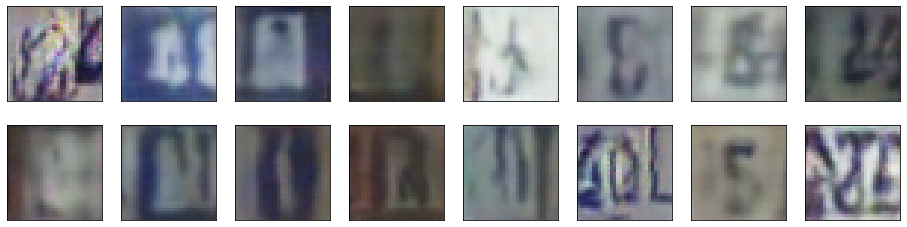

In [25]:
import matplotlib.pyplot as plt
# Model 0
# The parameters are all default values.
# Baseline
G=torch.load("./model/G0.pkl")
if train_on_gpu:
    fixed_z = fixed_z.cuda()
samples_z = G(fixed_z)
samples = []
samples.append(samples_z)
_ = view_samples(-1, samples)#new result1

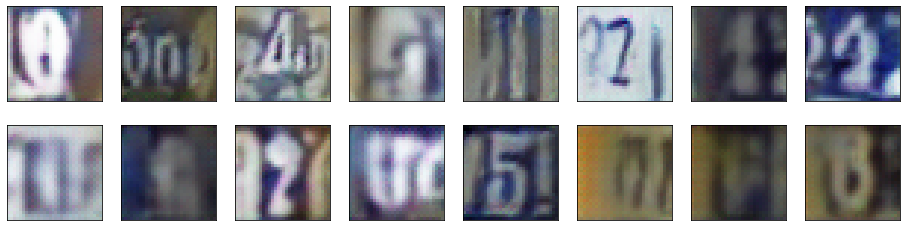

In [26]:
# Model 1
# The parameters are all default values.
# Use scheduler. 
#After each epoch , the learning rate of G and D decrese by 5% 
G=torch.load("./model/G1.pkl")
if train_on_gpu:
    fixed_z = fixed_z.cuda()
samples_z = G(fixed_z)
samples = []
samples.append(samples_z)
_ = view_samples(-1, samples)#new result1

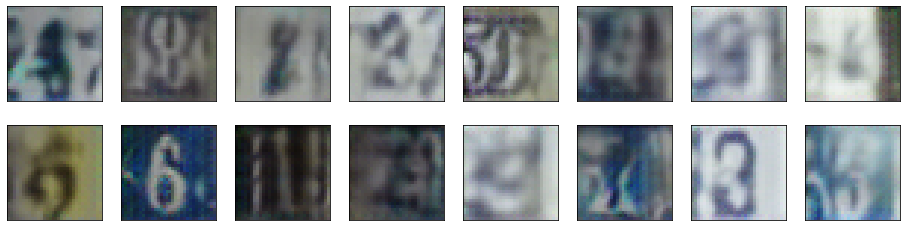

In [27]:
# Model 2
# The parameters are all default values.
# Use scheduler. 
#After each epoch , the learning rate of D decrese by 5% and the learning rate of D decrese by 3% 
#In my opinion, it's a good option because it can avoid the case that discriminator become too strong and generator can hardly learn anything. 
G=torch.load("./model/G2.pkl")
if train_on_gpu:
    fixed_z = fixed_z.cuda()
samples_z = G(fixed_z)
samples = []
samples.append(samples_z)
_ = view_samples(-1, samples)#new result1

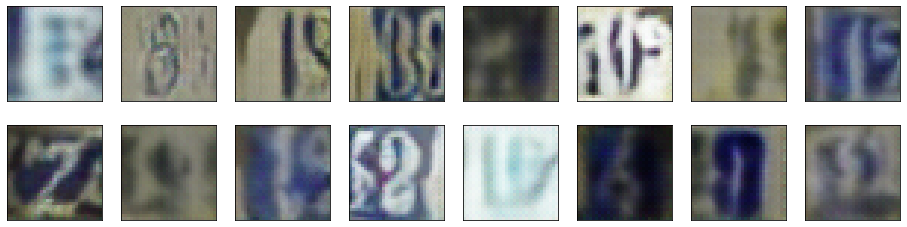

In [28]:
# Model 3
# Use 0.0003 as learning rate(default value is 0.0002)
# Use scheduler. 
#After each epoch , the learning rate of D decrese by 5% and the learning rate of D decrese by 3% 
#Higher learning rate doesn't bring higher quality images.
G=torch.load("./model/G3.pkl")
if train_on_gpu:
    fixed_z = fixed_z.cuda()
samples_z = G(fixed_z)
samples = []
samples.append(samples_z)
_ = view_samples(-1, samples)#new result1

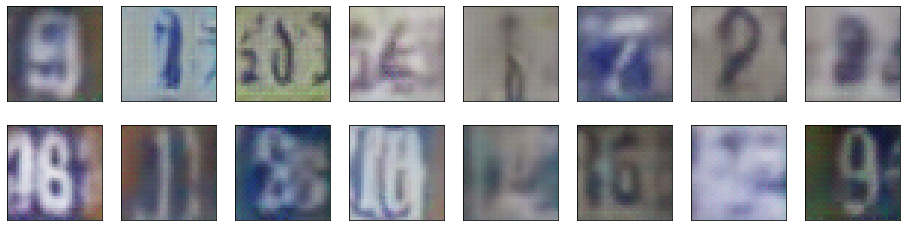

In [29]:
# Model 4
# The parameters are all default values.
# Only train 30 epochs
# Use scheduler. 
# After each epoch , the learning rate of D decrese by 5% and the learning rate of D decrese by 3% 
# With lower epoch number, the model still works perfectly. So maybe we don't need too many times of epoch.
# I personally think it's the best model among the five models. It use only 60% of time to build a good model.  
G=torch.load("./model/G4.pkl")
if train_on_gpu:
    fixed_z = fixed_z.cuda()
samples_z = G(fixed_z)
samples = []
samples.append(samples_z)
_ = view_samples(-1, samples)#new result1

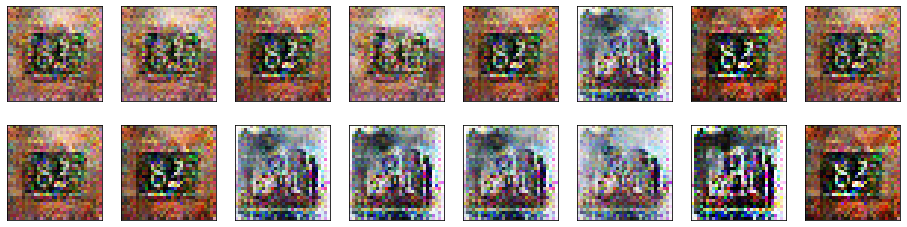

In [30]:
# This model is trained base on my collected data.
# The dataset is small, with only 30 images.
# I train for 10000 rounds. It works ok, I can tell some similar backgrounds and a number in the image.
# However, some of the number and the backround are  duplicate. It's the problem of using small dataset.
G=torch.load("./model/G_my.pkl")
if train_on_gpu:
    fixed_z = fixed_z.cuda()
samples_z = G(fixed_z)
samples = []
samples.append(samples_z)
_ = view_samples(-1, samples)#new result1